In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

from cov import util, viz

sns.set(style="ticks", palette="tab10")

# load data and make adata object

This notebook looks at the expression of ACE2 and TMPRSS2 in the mouse olfactory bulb.

To run this notebook:
* Download the `GSE148360_Datta_integratedOB_UMAP_noDoublets.csv.gz`, `GSE148360_Linnarsson_integratedOB_UMAP_noDoublets.csv.gz` and `GSE148360_OB_2016Dec_all_counts.csv.gz` files from the NCBI GEO at [GSE148360](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE148360) and save them to `data/raw/GSE148360_OB`. 
* Also download the [l1_olfactory.loom](https://storage.googleapis.com/linnarsson-lab-loom/l1_olfactory.loom) file from linnarsson lab's http://mousebrain.org/ data and add it to `data/raw/GSE148360_OB` folder.

For the Smart-seq2 data from individual dopamine neurons, download the `GSE151709_DAneurons_tpm.csv.gz` file from the NCBI GEO at [GSE151709](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE151709) and add it to `data/raw/GSE148360_OB` folder.

In [3]:
data_folds = util.get_data_folders()
ob_fold = util.get_raw_folders("mouse_OB")

In [4]:
ad_fn = data_folds.processed / "Mouse_OB.h5ad"
save = True
if ad_fn.exists():
    print("Loading h5ad file")
    adata = sc.read(ad_fn)
else:
    df_meta_d = pd.read_csv(
        ob_fold / "GSE148360_Datta_integratedOB_UMAP_noDoublets.csv.gz", index_col=0
    )
    df_meta_l = pd.read_csv(
        ob_fold / "GSE148360_Linnarsson_integratedOB_UMAP_noDoublets.csv", index_col=0
    )
    # takes a while to read gzipped csv file
    print("Loading drop-seq data")
    df_counts = pd.read_csv(
        ob_fold / "GSE148360_OB_2016Dec_all_counts.csv.gz",
        low_memory=False,
        index_col=0,
    )

    assert df_meta_d.index.isin(df_counts.columns).all()

    # make into adata, keeping non_doublet cells
    adata_d = AnnData(df_counts[df_meta_d.index].T)
    adata_d.X = sparse.csr_matrix(adata_d.X)
    assert adata_d.obs_names.equals(df_meta_d.index)
    adata_d.obs = adata_d.obs.join(df_meta_d)

    print("Loading Linnarsson data")
    adata_l = sc.read_loom(ob_fold / "l1_olfactory.loom")
    adata_l.var_names_make_unique()
    adata_l.obs_names_make_unique(join=".")
    assert df_meta_l.index.isin(adata_l.obs_names).all()
    # keep cell subset used
    adata_l_keep = adata_l[df_meta_l.index].copy()
    adata_l_keep.obs = adata_l_keep.obs.join(df_meta_l)

    # concatenate
    adata = adata_d.concatenate(adata_l_keep, index_unique=None, join="outer")
    adata.obsm["X_umap"] = adata.obs[["UMAP_1", "UMAP_2"]].values

    adata.raw = adata.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)

    if save:
        print(f"Saving h5ad file to {ad_fn}")
        adata.write_h5ad(ad_fn)
print(adata)

Loading h5ad file
AnnData object with n_obs × n_vars = 47477 × 37751
    obs: 'UMAP_1', 'UMAP_2', 'seurat_clusters', 'Cell_class', 'Age', 'AnalysisPool', 'AnalysisProject', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbabil

# example plots

/Users/davidbrann/miniconda3/envs/covid/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


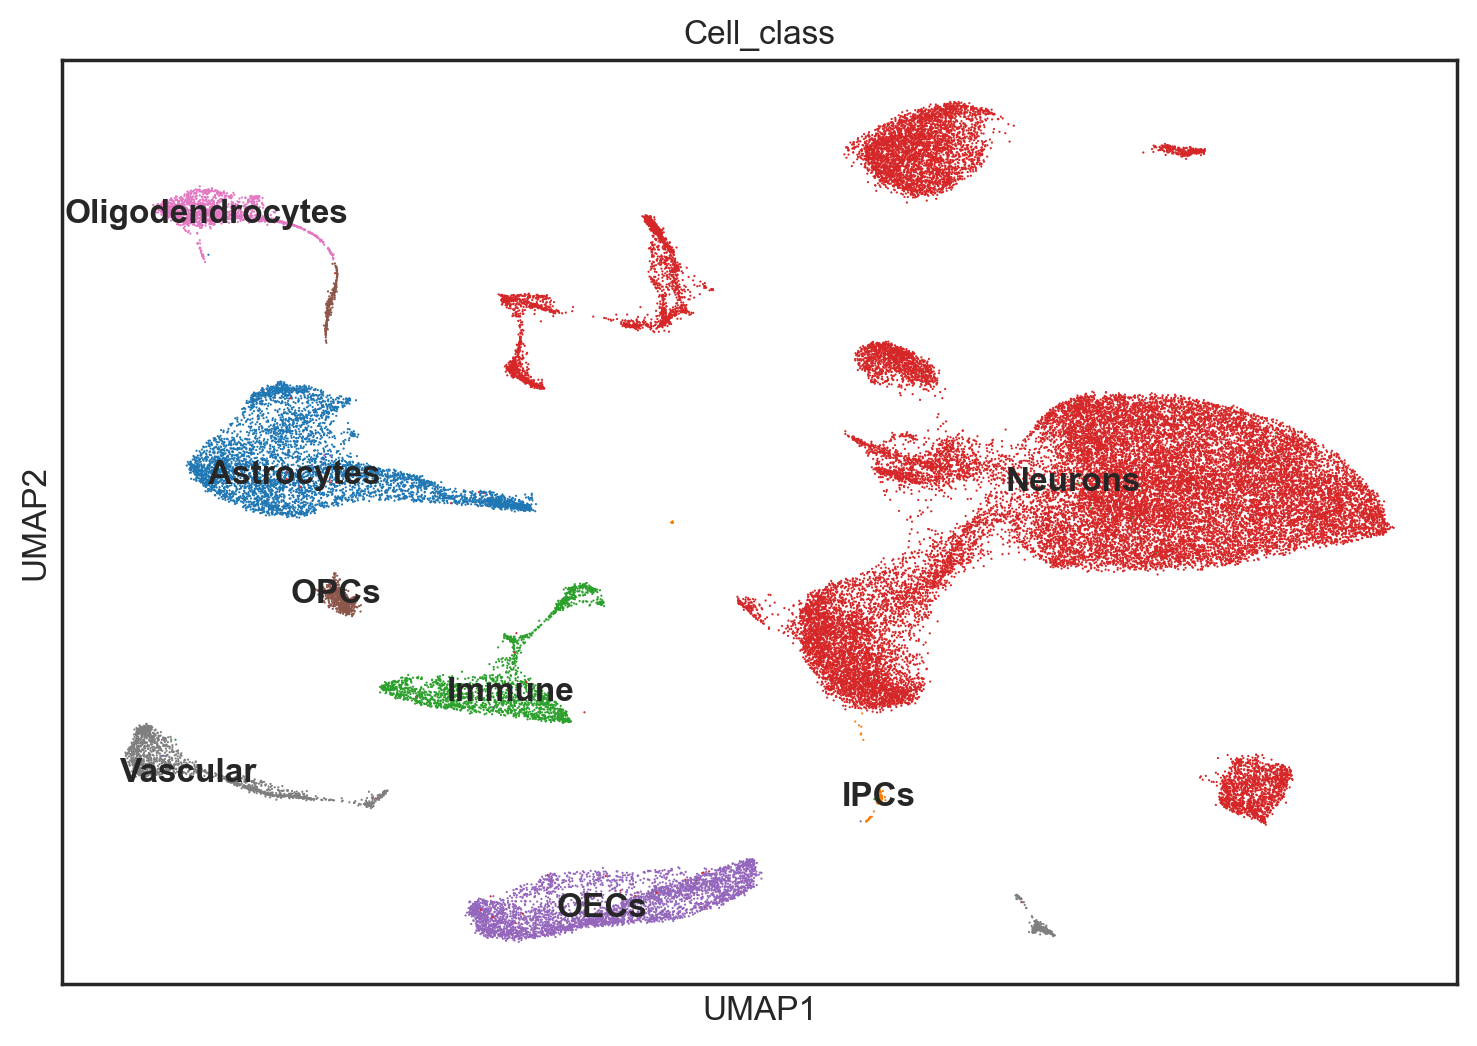

/Users/davidbrann/miniconda3/envs/covid/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


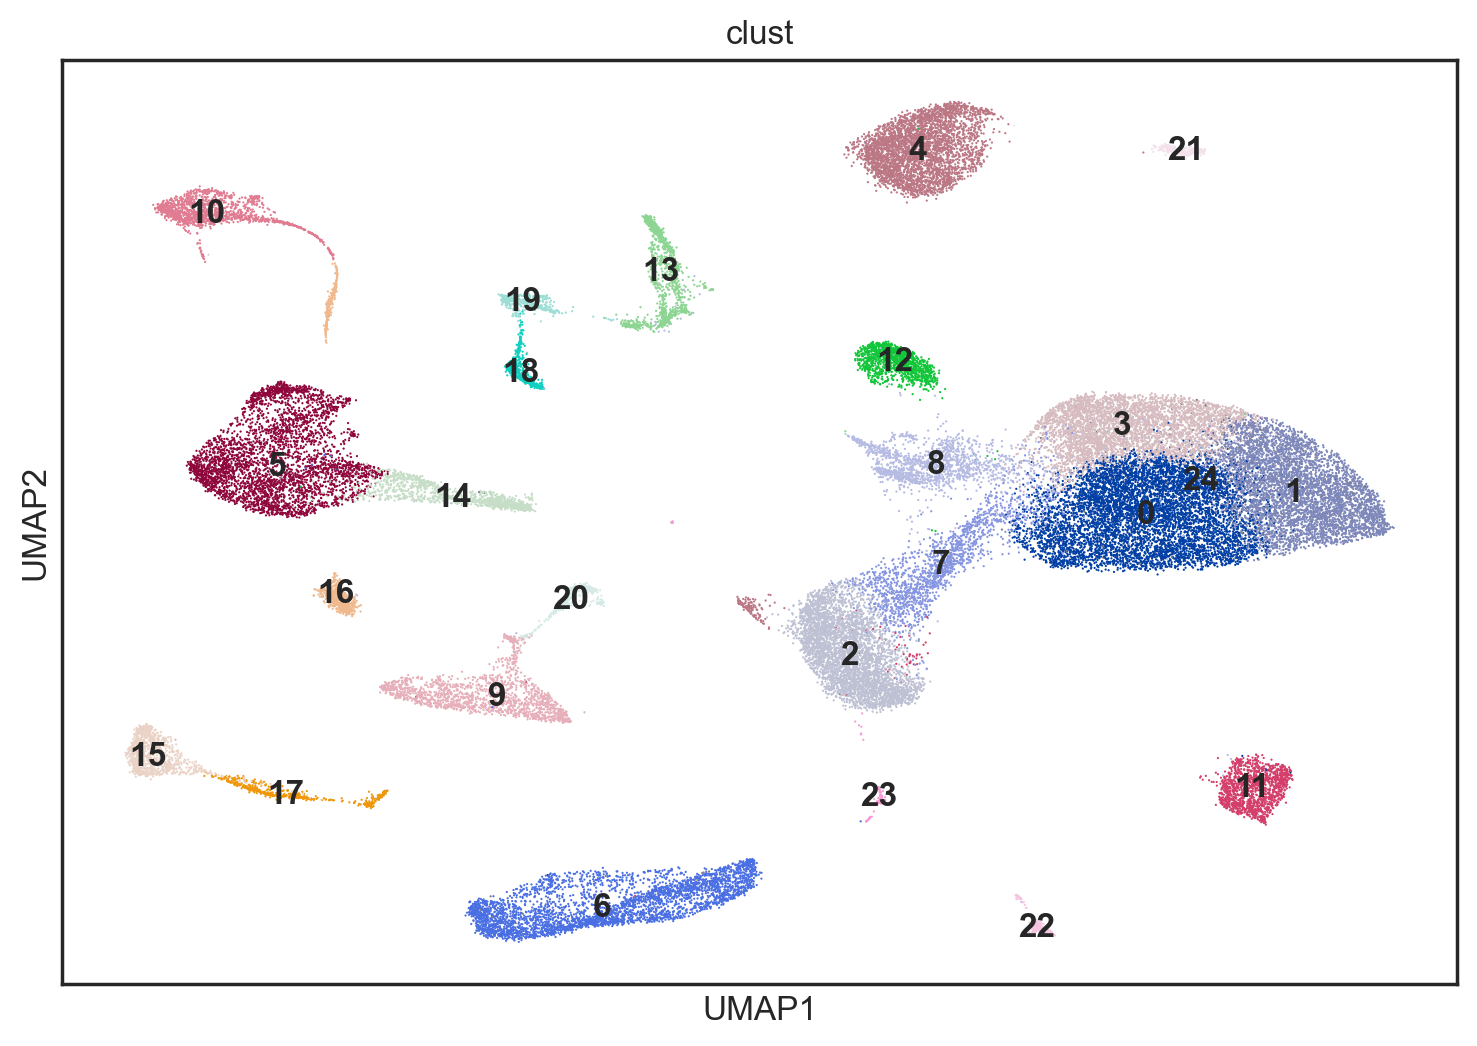

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
sc.pl.umap(adata, color="Cell_class", legend_loc="on data", ax=ax);
adata.obs["clust"] = pd.Categorical(adata.obs.seurat_clusters)
fig, ax = plt.subplots(figsize=(9,6))
sc.pl.umap(adata, color="clust", legend_loc="on data", ax=ax);

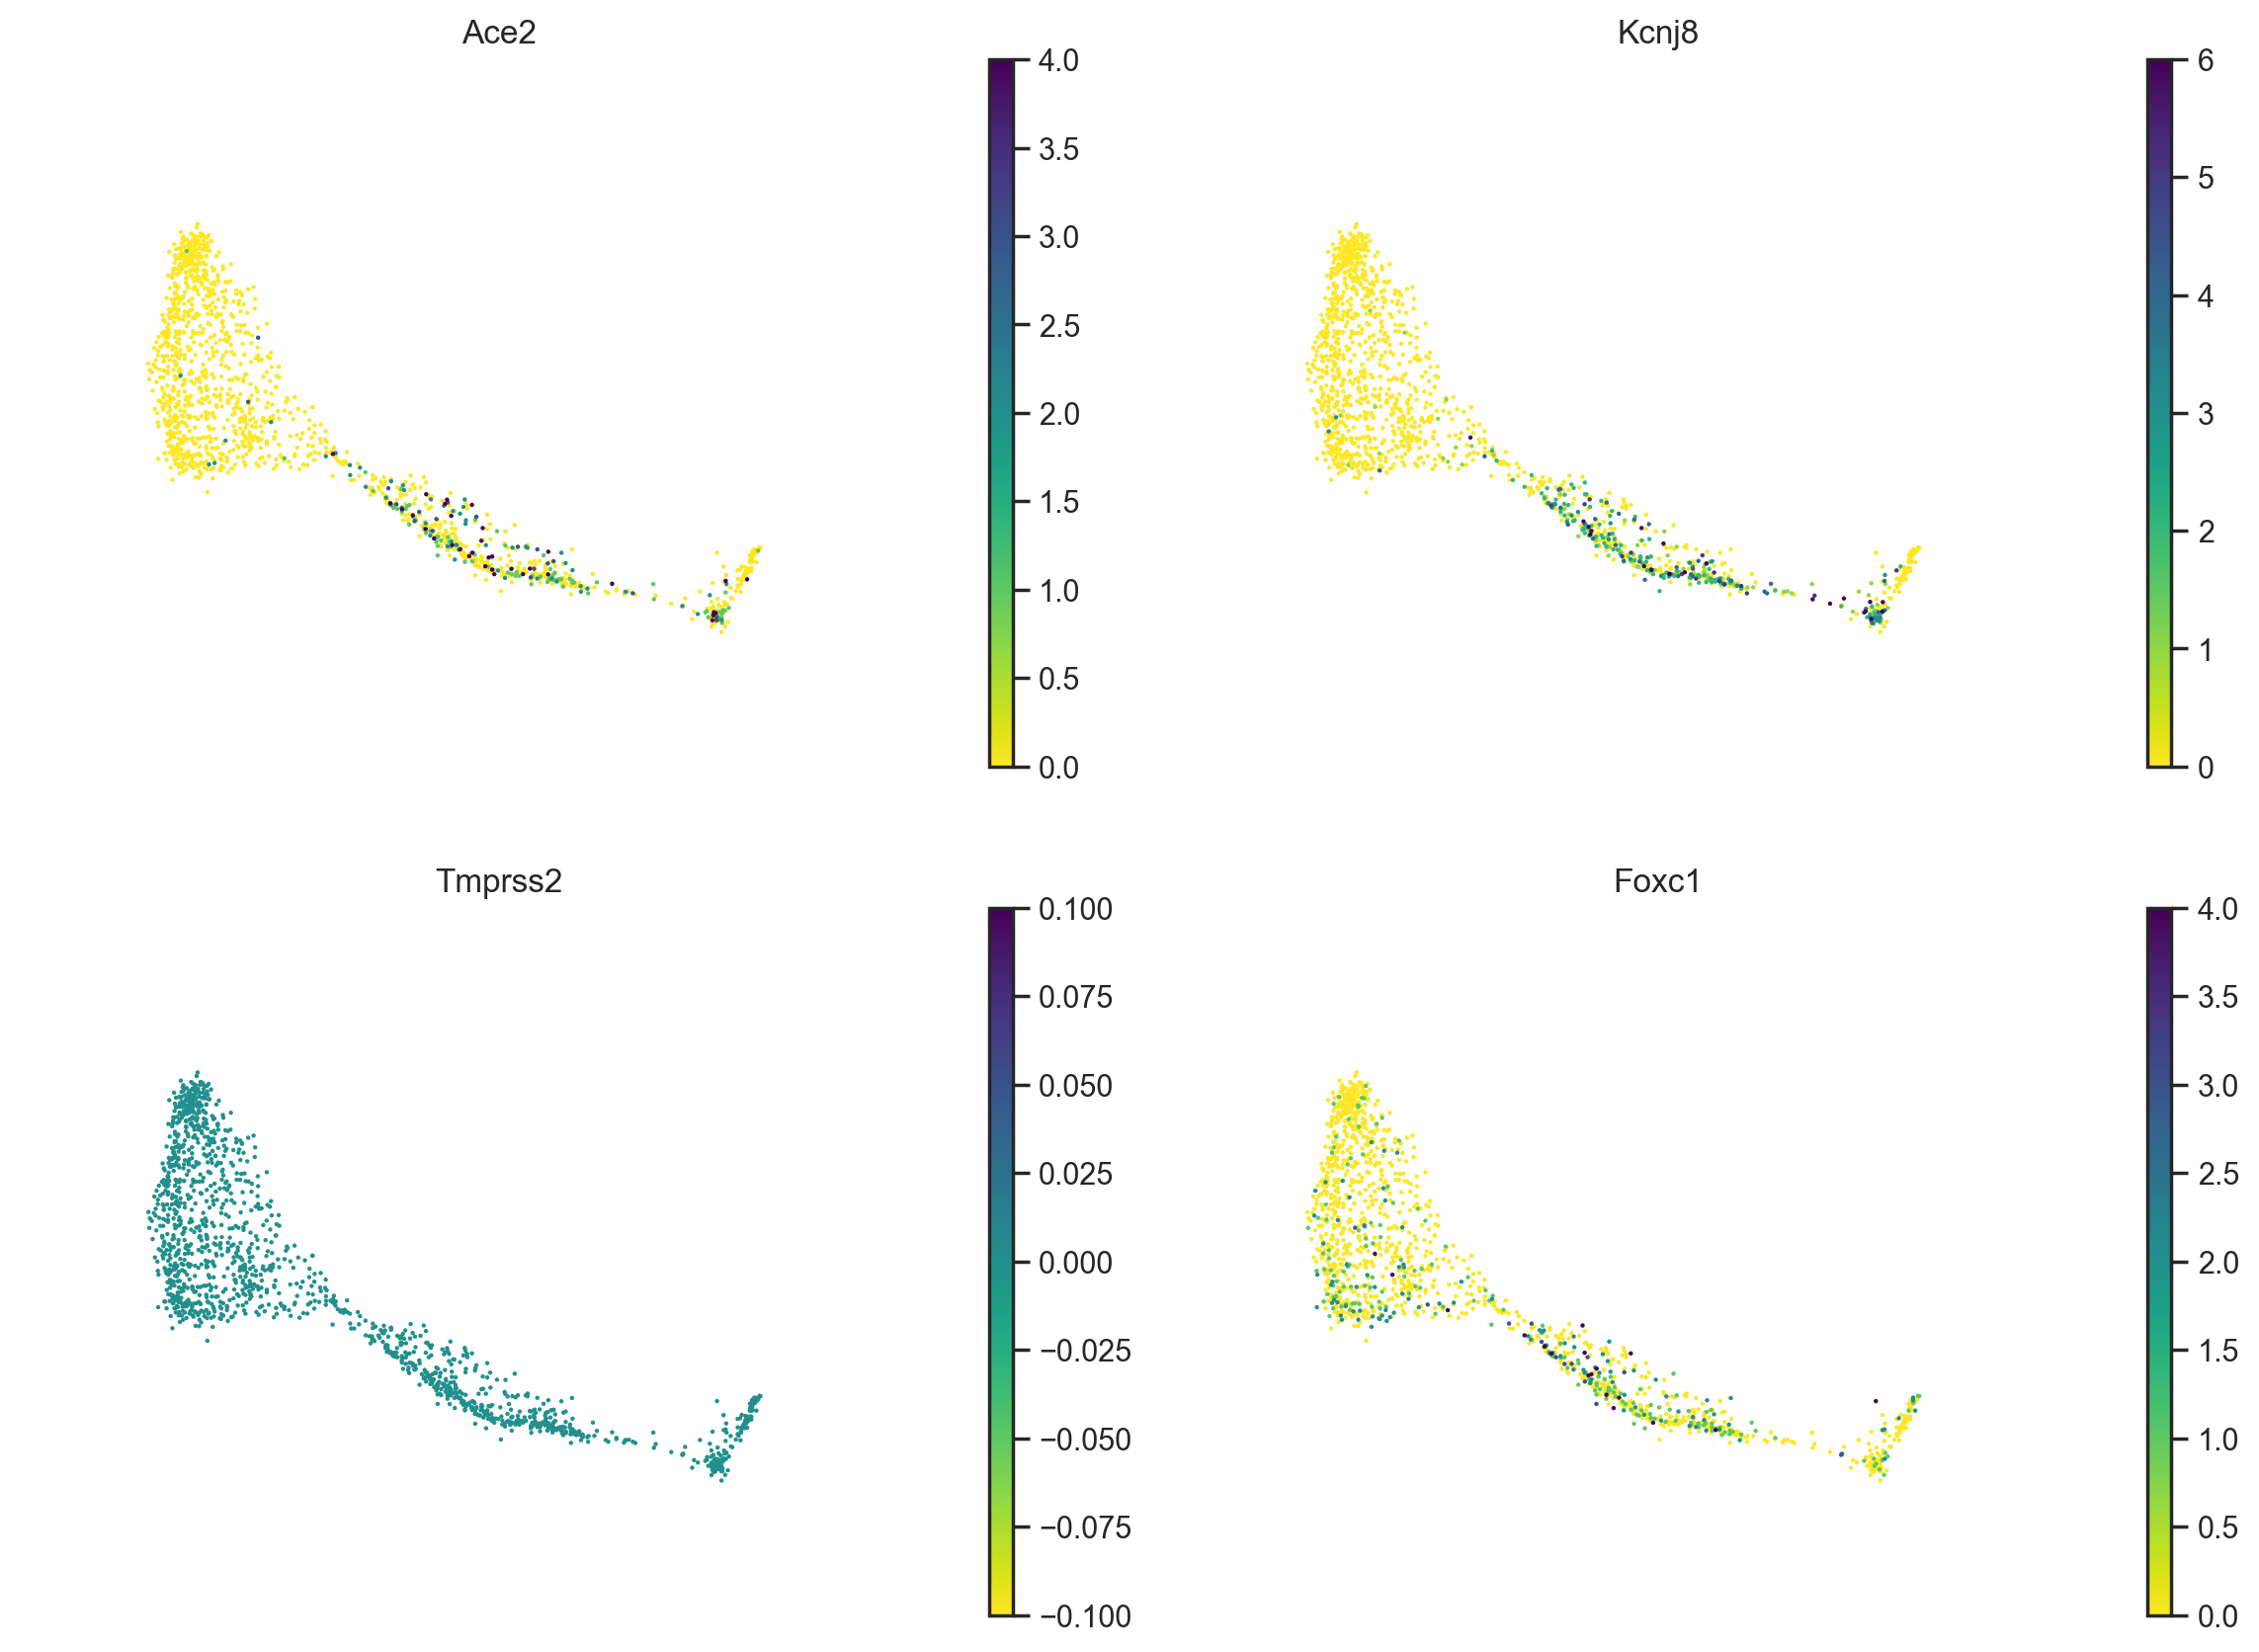

In [6]:
adata_vascular = adata[adata.obs.Cell_class == "Vascular"].copy()
fig = sc.pl.umap(
    adata_vascular,
    color=["Ace2", "Kcnj8", "Tmprss2", "Foxc1"],
    ncols=2,
    frameon=False,
    cmap="viridis_r",
    vmax="p99",
    s=10,
    hspace=0.2,
    wspace=0.1,
    return_fig=True,
)
for ax in fig.axes[::2]:
    ax.set_xlim(None, -7)
    ax.set_ylim(-11, -6)

# plot example CoV genes

In [7]:
cov_genes = [
    "Ace2",
    "Tmprss2",
    "Ctsb",
    "Ctsl",
    "Bsg",
    "Hspa5",
    "Dpp4",
    "Furin",
    "Anpep",
    "Tmprss11d",
    "St6gal1",
    "St3gal4",
    "Ceacam1",
]
genes_of_interest = ["Mlc1", "Itgam", "Top2a", "Snap25", "Frzb", "Olig2", "Foxc1"]

subset_order = [
    "Astrocytes",
    "Immune",
    "IPCs",
    "Neurons",
    "OECs",
    "Oligodendrocytes",
    "OPCs",
    "Vascular",
]

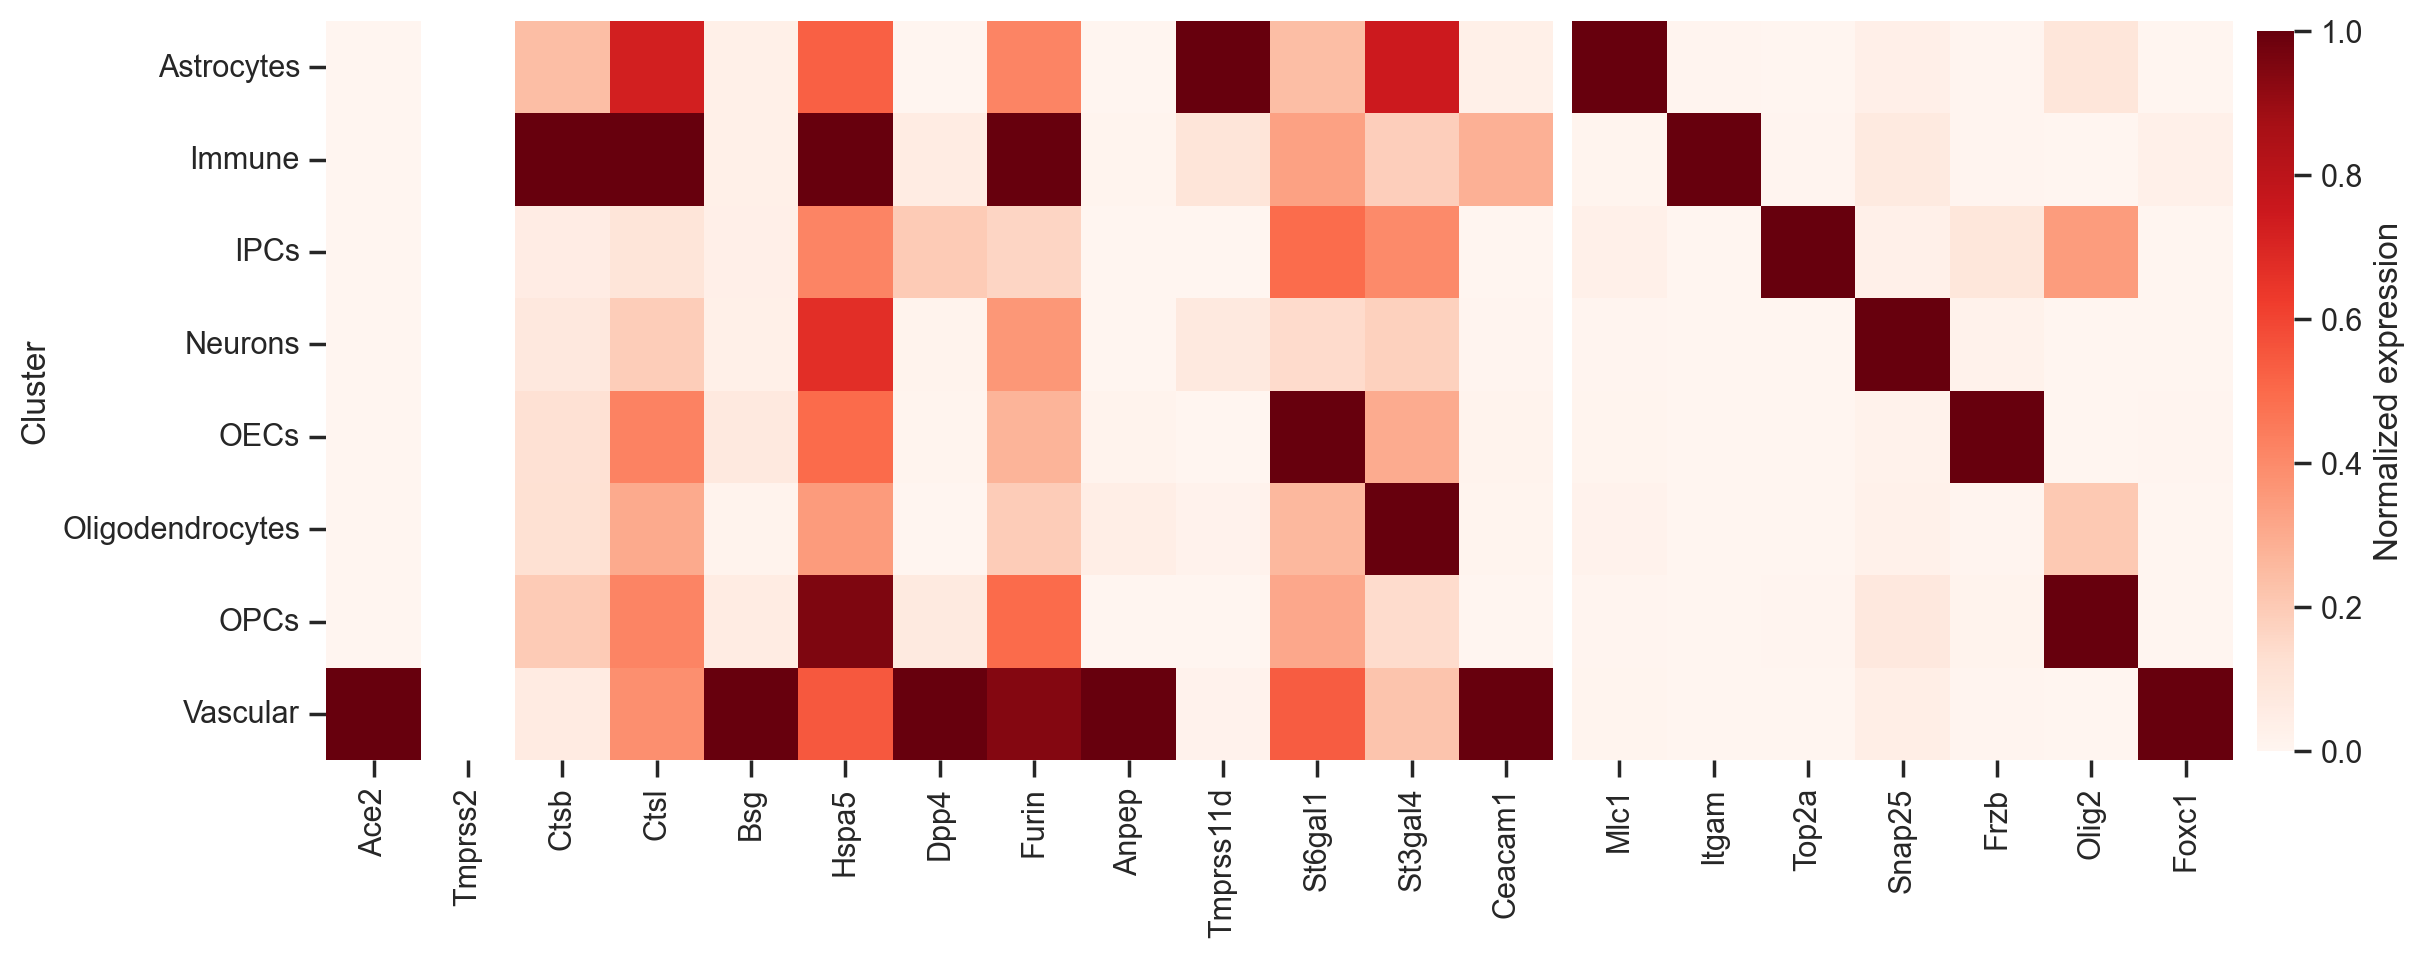

In [8]:
df_norm = viz.plot_heatmap(
    adata, genes_of_interest, cov_genes, subset_order, clust="Cell_class"
)

# plot pct of ACE2+ cells

Text(0.5, 0, '')

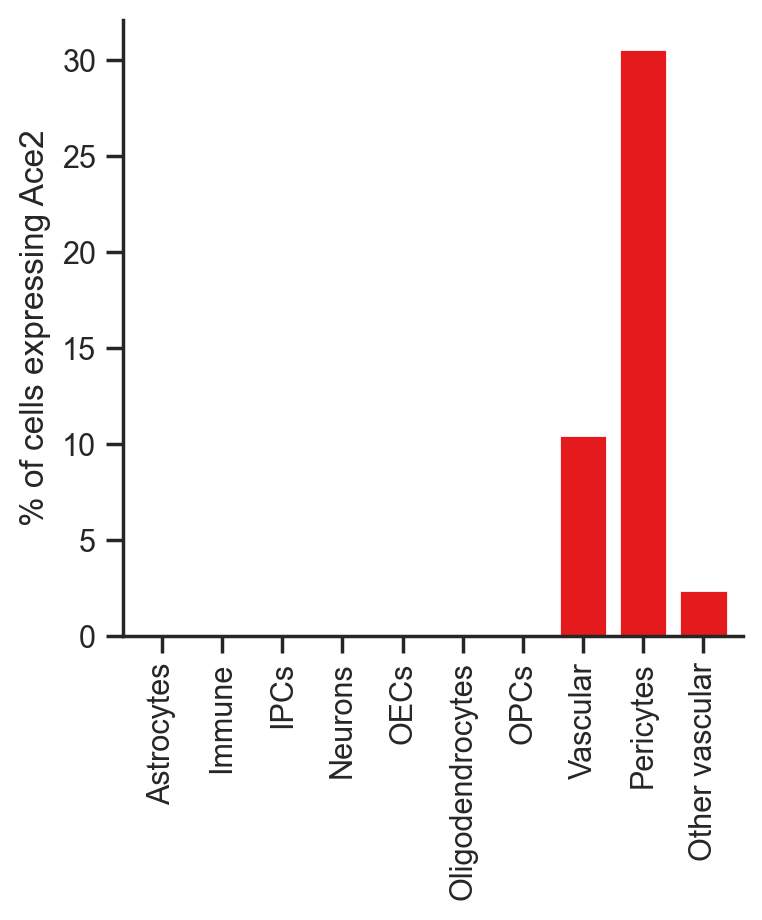

In [9]:
df_pct = (sc.get.obs_df(adata, ["Ace2"]) > 0).join(
    adata.obs[["Cell_class", "seurat_clusters"]]
)
df_pct_class_mean = df_pct.groupby("Cell_class").Ace2.mean().loc[subset_order] * 100
# also sub-divide vascular into pericytes and other
df_pct_sub_cluster = df_pct.groupby("seurat_clusters").Ace2.mean().loc[[17, 15]] * 100
df_pct_sub_cluster.index = ["Pericytes", "Other vascular"]
df_to_plot = pd.concat([df_pct_class_mean, df_pct_sub_cluster])

fig, ax = plt.subplots(figsize=(4, 4))
df_to_plot.plot.bar(ax=ax, color=plt.cm.Set1(0), width=0.8)
ax.legend().remove()
sns.despine()
ax.set_ylabel("% of cells expressing Ace2")
ax.set_xlabel(None)

# Dopamine neurons

In [10]:
df_tpm = pd.read_csv(ob_fold / "GSE151709_DAneurons_tpm.csv.gz", index_col=0)
df_tpm_use = df_tpm.loc[:, ~df_tpm.columns.str.contains("MiSeq")]
da_genes = cov_genes + ["Snap25", "Th"]
df_melt = np.log2(df_tpm.loc[da_genes] + 1).T.melt()

Text(0.5, 0, '')

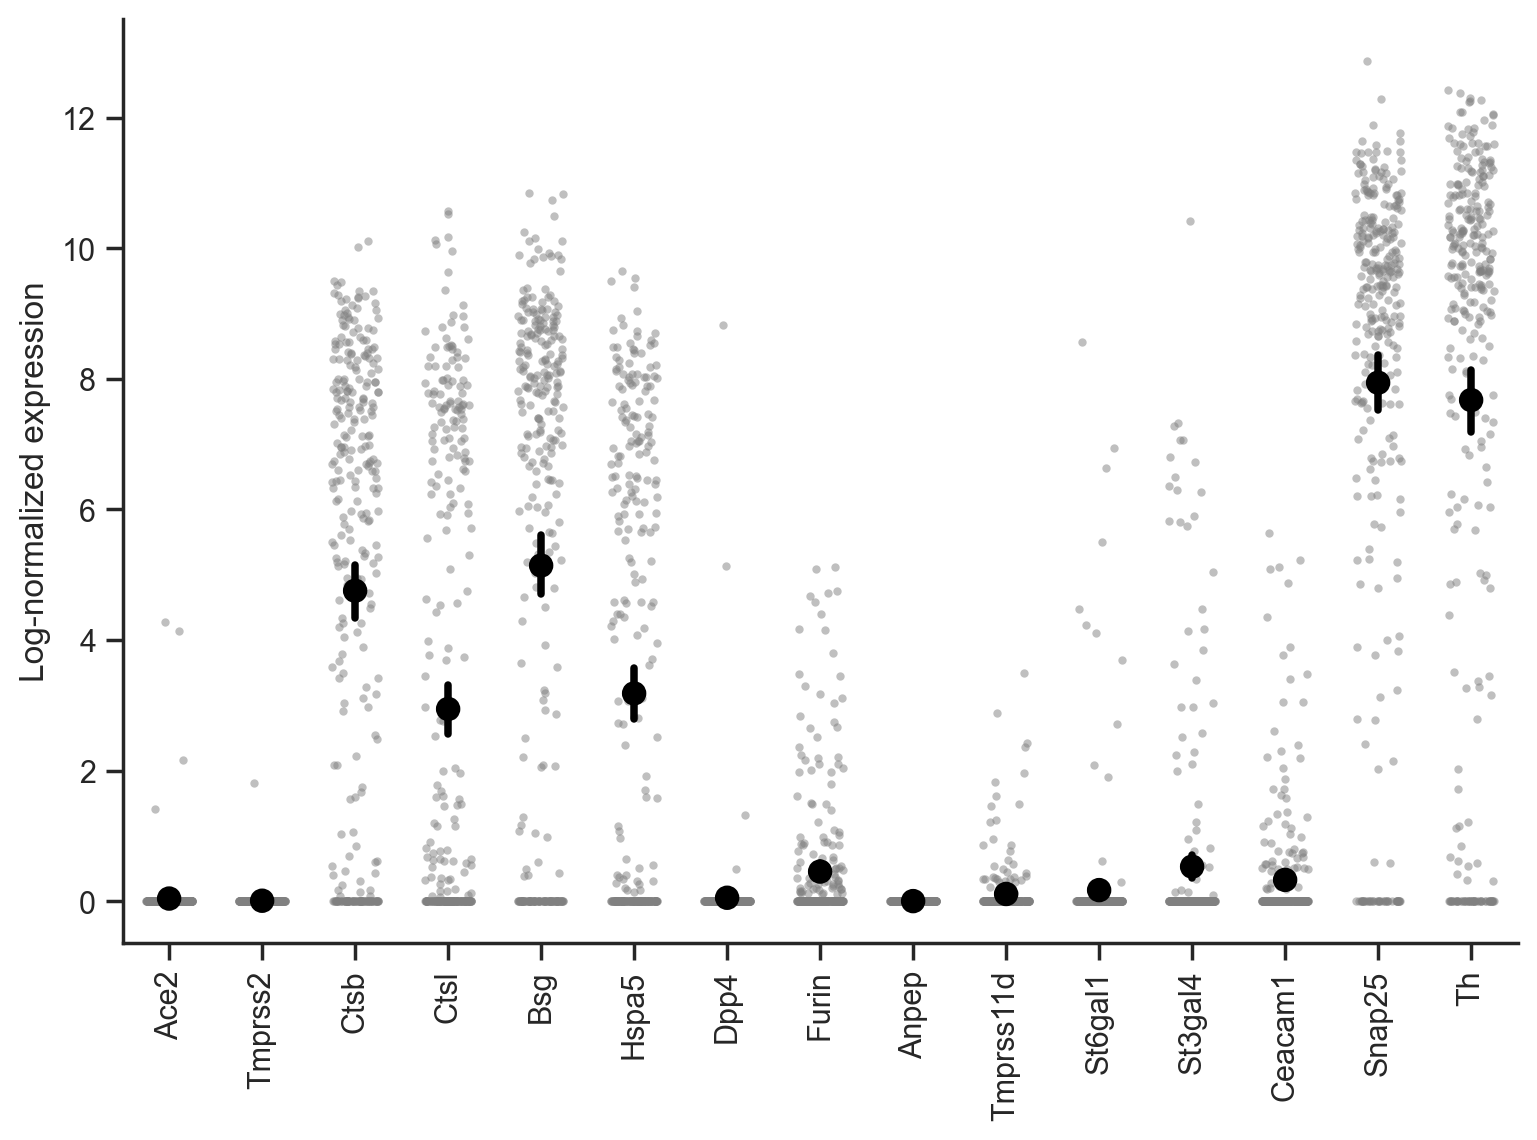

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.stripplot(
    data=df_melt,
    ax=ax,
    x="variable",
    y="value",
    size=3,
    alpha=0.5,
    jitter=0.25,
    color="0.5",
    zorder=-10,
)
sns.pointplot(
    data=df_melt,
    ax=ax,
    x="variable",
    y="value",
    join=False,
    color="k",
)
ax.set_ylabel("Log-normalized expression")
sns.despine()
plt.xticks(rotation=90)
ax.set_xlabel(None)